# Deep Fake Detection. Vgg16

Importamos las librerías necesarias para el proyecto. Entre ellas, se encuentran las librerías de Pytorch, que nos permitirán utilizar la red convolucional VGG16 pre-entrenada para adaptarla a nuestro problema (transfer learning).

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import models
import torchvision.transforms as transforms

from torch.optim import lr_scheduler

from torch.utils.data import random_split, DataLoader
from dataset_handlers.vgg16.vgg16_feature_dataset import FeatureDataset

from sklearn.model_selection import KFold

import os
from PIL import Image
from matplotlib import pyplot as plt

Lo primero será cargar el modelo VGG16 con sus pesos ya entrenados, y comprobamos que funciona correctamente para nuestro dataset.

In [20]:
vgg16 = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

### Cargamos nuestro dataset

Cargado el modelo, podemos proceder a cargar nuestro dataset. Se utilizará un dataset de Kaggle, que contiene entorno a 2000 imágenes rostros de personas, balanceadas entre deep-fakes e imágenes reales. Se divide en dos carpetas, una para cada tipo de imagen.

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [7]:
dataset = torchvision.datasets.ImageFolder(
    root='data/real_and_fake_face',
    transform=transform
)

In [8]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [9]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

A continuación, comprobamos que los datos transformados son compatibles con el modelo

In [10]:
img, _ = next(iter(train_loader))
out = vgg16(img)
print(torch.argmax(out, dim=1))

tensor([669, 903, 838, 903, 617, 793, 452, 452, 643, 903, 452, 678, 457, 838,
        793, 452, 903, 793, 691, 876, 838, 903, 838, 457, 452, 452, 903, 838,
        617, 433, 903, 433])


### Aplicamos transfer learning

In [11]:
vgg16.classifier[0] = nn.Linear(25088, 512)
vgg16.classifier[3] = nn.Linear(512, 128)
vgg16.classifier[6] = nn.Linear(128, 2)

In [12]:
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
critereon = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters() ,lr=0.0001)

In [16]:
def accuracy(data_loader, model):
    acc = 0
    for i, (image, label) in enumerate(data_loader, 1):
        image = image.to(device)
        label = label.to(device)

        output = model(image)
        acc += (torch.argmax(output, dim=1) == label).sum().item()

    return acc / len(data_loader.dataset)

In [ ]:
acc_training_set = []
acc_val_set = []
l1_factor = 0.000001

for epoch in range(num_epochs):
    for i, (image, label) in enumerate(train_loader, 1):
        image = image.to(device)
        label = label.to(device)

        output = vgg16(image)
        loss = critereon(output, label)

        l1_regularization = torch.tensor(0., requires_grad=False)
        for param in vgg16.parameters():
            l1_regularization += torch.norm(param, 1)

        l1_regularization.requires_grad_(True)
        print(l1_regularization)

        loss += l1_factor * l1_regularization

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            acc_val_set.append(accuracy(test_loader, vgg16))

            print('Epoch: {}/{}, Batch: {}, Loss: {:.6f}, Acc (val): {:.6f}'.format(epoch+1, num_epochs, i, loss.item(), acc_val_set[-1]))

    l1_factor *= 10

In [ ]:
acc = 0
for i, (image, label) in enumerate(test_loader, 1):
    image = image.to(device)
    label = label.to(device)

    output = vgg16(image)
    acc += (torch.argmax(output, dim=1) == label).sum().item()

print("Se ha obtenido un accuracy del ", acc/len(test_dataset)*100, "% en el conjunto de test")

## Fine-tuning

Modificaremos la última capa de la red para adaptarla a una red de clasificación binaria. Por defecto, la última capa de la red VGG16 es una capa densa con 1000 neuronas, que se corresponde con las 1000 clases de ImageNet. En nuestro caso, necesitamos una capa densa con 2 neuronas, que se corresponde con las clases real (1) y fake (0).

In [21]:
vgg16.classifier[0] = nn.Linear(25088, 512)
vgg16.classifier[3] = nn.Linear(512, 128)
vgg16.classifier[6] = nn.Linear(128, 2)

Solo entrenaremos las capas convolucionales de la red encargadas de detectar características más específicas. El resto de capas se mantendrán congeladas para evitar que se modifiquen los pesos ya entrenados. Para evitar el feedwforward desde la capa de entrada en la VGG-16, definimos un nuevo modelo que solo incluye las capas a reentrenar, y tomamos el dataset 'train_and_fake_conv_features' como entrada, que contiene los tensores de salida de la última capa convolucional del modelo original que queríamos congelar.

In [22]:
vgg16 = nn.Sequential(
    vgg16.features[24:],
    vgg16.avgpool,
    nn.Flatten(),
    vgg16.classifier
)

Dicho dataset lo cargaremos de la siguiente manera

In [24]:
transform = transforms.Compose([
    transforms.Resize((14, 14))
])

dataset = FeatureDataset("data/real_and_fake_conv_features", transform=transform)

In [25]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [26]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

A continuación, entrenamos el modelo definido

In [27]:
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
critereon = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001, weight_decay=0.0001)

In [29]:
acc_training_set = []
acc_val_set = []
l1_factor = 0.0001

for epoch in range(num_epochs):
    for i, (image, label) in enumerate(train_loader, 1):
        image = image.to(device)
        label = label.to(device)

        output = vgg16(image)
        loss = critereon(output, label)

        l1_regularization = torch.tensor(0., requires_grad=False)
        for param in vgg16.parameters():
            l1_regularization += torch.norm(param, 1)

        l1_regularization.requires_grad_(True)

        loss += l1_factor * l1_regularization

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            acc_training_set.append(accuracy(train_loader, vgg16))
            acc_val_set.append(accuracy(val_loader, vgg16))

            print('Epoch: {}/{}, Batch: {}, Loss: {:.6f}, Acc (train): {:.6f}, Acc (val): {:.6f}'
                  .format(epoch+1, num_epochs, i, loss.item(), acc_training_set[-1], acc_val_set[-1]))

Epoch: 1/10, Batch: 10, Loss: 13.450161, Acc (train): 0.585441, Acc (val): 0.541284
Epoch: 1/10, Batch: 20, Loss: 12.711085, Acc (train): 0.630651, Acc (val): 0.593272
Epoch: 1/10, Batch: 30, Loss: 11.988889, Acc (train): 0.656705, Acc (val): 0.596330
Epoch: 1/10, Batch: 40, Loss: 11.354239, Acc (train): 0.675862, Acc (val): 0.636086
Epoch: 2/10, Batch: 10, Loss: 10.811815, Acc (train): 0.701149, Acc (val): 0.568807
Epoch: 2/10, Batch: 20, Loss: 10.360247, Acc (train): 0.742529, Acc (val): 0.596330
Epoch: 2/10, Batch: 30, Loss: 9.901059, Acc (train): 0.754789, Acc (val): 0.590214
Epoch: 2/10, Batch: 40, Loss: 9.503146, Acc (train): 0.745594, Acc (val): 0.599388
Epoch: 3/10, Batch: 10, Loss: 9.098294, Acc (train): 0.804598, Acc (val): 0.596330
Epoch: 3/10, Batch: 20, Loss: 8.963779, Acc (train): 0.818391, Acc (val): 0.617737
Epoch: 3/10, Batch: 30, Loss: 8.754753, Acc (train): 0.860536, Acc (val): 0.584098
Epoch: 3/10, Batch: 40, Loss: 8.329248, Acc (train): 0.883525, Acc (val): 0.60244

In [ ]:
acc = 0
for i, (image, label) in enumerate(train_loader, 1):
    image = image.to(device)
    label = label.to(device)

    output = vgg16(image)
    acc += (torch.argmax(output, dim=1) == label).sum().item()

print("Se ha obtenido un accuracy del ", acc/len(train_dataset)*100, "% en el conjunto de entrenamiento")

Se ha obtenido un accuracy del  100.0 % en el conjunto de entrenamiento


In [1]:
acc = 0
for i, (image, label) in enumerate(test_loader, 1):
    image = image.to(device)
    label = label.to(device)

    output = vgg16(image)
    acc += (torch.argmax(output, dim=1) == label).sum().item()

print("Se ha obtenido un accuracy del ", acc/len(test_dataset)*100, "% en el conjunto de test")

Se ha obtenido un accuracy del  61.3% en el conjunto de test


El modelo se sobreajusta enhormemente, por lo que se procede al desarrollo de un modelo con un menor número de capas en su parte densa.

# Modelo con menos capas convolutivas (y regularización L1)

El sobreajuste quizás se deba a que el modelo VGG16 es demasiado complejo para nuestro problema. Por ello, se desarrolla un nuevo modelo con menos capas convolutivas, y se añade regularización L1 para evitar el sobreajuste.

In [73]:
vgg16 = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

Le quitaremos las dos últimas capas convolutivas, y además haremos fine-tuning al modelo entrenando, a parte de su capa FC, las dos últimas capas convolutivas.

In [84]:
reduced = nn.Sequential(
    vgg16.features[17:21],
    nn.AdaptiveAvgPool2d((7,7)),
    nn.Flatten(),
    nn.Linear(25088, 128, bias=True),
    nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.AlphaDropout(p=0.5, inplace=False),
    nn.Linear(128, 2, bias=True)
)

El modelo resultante se vería de la siguiente forma

In [85]:
reduced

Sequential(
  (0): Sequential(
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): ReLU(inplace=True)
    (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (20): ReLU(inplace=True)
  )
  (1): AdaptiveAvgPool2d(output_size=(7, 7))
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=25088, out_features=128, bias=True)
  (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): AlphaDropout(p=0.5, inplace=False)
  (7): Linear(in_features=128, out_features=2, bias=True)
)

A continuación, cargamos el conjunto de datos

In [87]:
transform = transforms.Compose([
    transforms.Resize((28, 28), antialias=True),
])

dataset = FeatureDataset("data/real_and_fake_vgg16_17", transform=transform)

y lo dividimos en train y test

In [88]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [89]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

## Entrenamos el modelo

Tendremos un proceso de entrenamiento con 10 epochs, y un batch size de 32 (definido en el chunck anterior). El optimizador será Adam, y la función de pérdida será la Cross Entropy.

In [90]:
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [91]:
critereon = nn.CrossEntropyLoss()
optimizer = optim.Adam(reduced.parameters() ,lr=0.0001, weight_decay=0.0001)

In [93]:
acc_training_set = []
acc_val_set = []
l1_lambda = 0.0001

for epoch in range(num_epochs):
    for i, (image, label) in enumerate(train_loader, 1):
        image = image.to(device)
        label = label.to(device)

        output = reduced(image)
        loss = critereon(output, label)

        reduced.requires_grad_(True)
        l1_regularization = torch.tensor(0., requires_grad=False)
        for param in reduced.parameters():
            l1_regularization += torch.norm(param, 1)

        l1_regularization.requires_grad_(True)
    
        loss += l1_lambda * l1_regularization

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            acc_training_set.append(accuracy(train_loader, reduced))
            acc_val_set.append(accuracy(val_loader, reduced))

            print('Epoch: {}/{}, Batch: {}, Loss: {:.6f}, Acc (train): {:.6f}, Acc (val): {:.6f}'
                  .format(epoch+1, num_epochs, i, loss.item(), acc_training_set[-1], acc_val_set[-1]))

Epoch: 1/10, Batch: 10, Loss: 6.351156, Acc (train): 0.619923, Acc (val): 0.645260
Epoch: 1/10, Batch: 20, Loss: 5.862018, Acc (train): 0.643678, Acc (val): 0.663609
Epoch: 1/10, Batch: 30, Loss: 5.850484, Acc (train): 0.674330, Acc (val): 0.626911
Epoch: 1/10, Batch: 40, Loss: 5.584894, Acc (train): 0.702682, Acc (val): 0.581040
Epoch: 2/10, Batch: 10, Loss: 5.446470, Acc (train): 0.718774, Acc (val): 0.602446
Epoch: 2/10, Batch: 20, Loss: 5.408345, Acc (train): 0.723372, Acc (val): 0.623853
Epoch: 2/10, Batch: 30, Loss: 5.200565, Acc (train): 0.760153, Acc (val): 0.593272
Epoch: 2/10, Batch: 40, Loss: 4.908703, Acc (train): 0.762452, Acc (val): 0.654434
Epoch: 3/10, Batch: 10, Loss: 4.846478, Acc (train): 0.777011, Acc (val): 0.651376
Epoch: 3/10, Batch: 20, Loss: 4.777230, Acc (train): 0.797701, Acc (val): 0.614679
Epoch: 3/10, Batch: 30, Loss: 4.759680, Acc (train): 0.828352, Acc (val): 0.669725
Epoch: 3/10, Batch: 40, Loss: 4.589561, Acc (train): 0.829119, Acc (val): 0.651376
Epoc

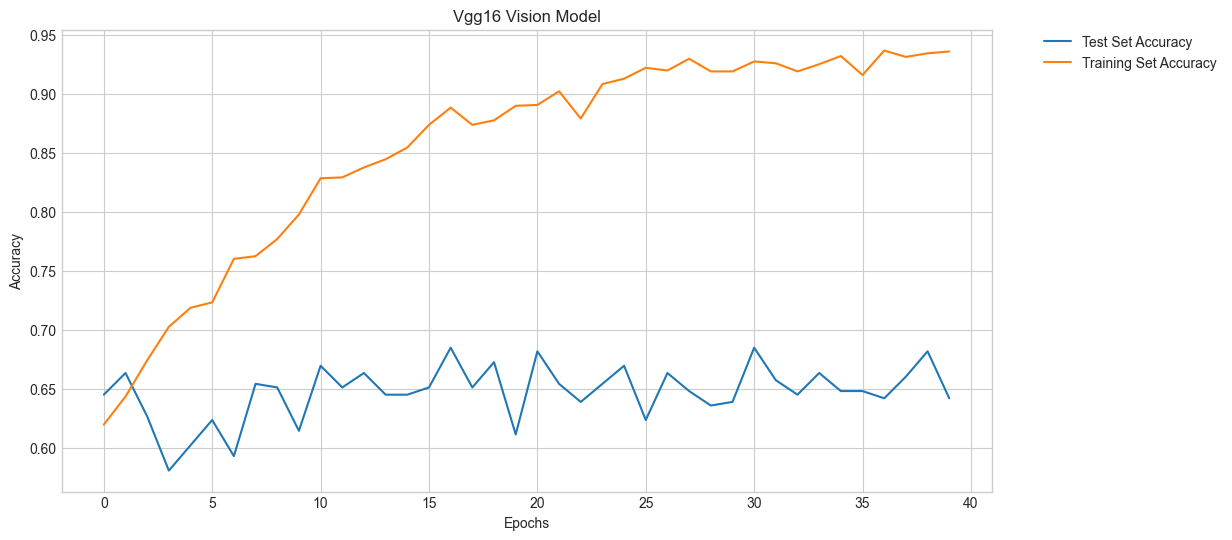

# Cross-Validation (Con regularización L1 y L2)

Con el objetivo de disminuir el sobreajuste, se procede a realizar cross-validation. Para ello, se divide el dataset en 5 partes o folds, y se entrena el modelo 5 veces, cada vez con una parte distinta como test y el resto como train. Se calcula la media de las métricas obtenidas en cada entrenamiento.

Utilizaremos la capa FC que mejores resultados nos ha proporcionado hasta ahora

In [2]:
vgg16 = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
vgg16.classifier[0] = nn.Linear(25088, 512)
vgg16.classifier[3] = nn.Linear(512, 128)
vgg16.classifier[6] = nn.Linear(128, 2)

El modelo tendrá todas las capas convolutivas congeladas del vgg16, aunque solo reentrenaremos las tres últimas, ademas de la FC

In [3]:
vgg16 = nn.Sequential(
    vgg16.features[24:],
    vgg16.avgpool,
    nn.Flatten(),
    vgg16.classifier
)

vgg16.eval()

Sequential(
  (0): Sequential(
    (24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (25): ReLU(inplace=True)
    (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (27): ReLU(inplace=True)
    (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (29): ReLU(inplace=True)
    (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(7, 7))
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Sequential(
    (0): Linear(in_features=25088, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

Procedemos nuevamente con la carga del conjunto de datos y lo dividimos en train y test

In [5]:
transform = transforms.Compose([
    transforms.Resize((14, 14), antialias=None)
])

dataset = FeatureDataset("data/real_and_fake_conv_features", transform=transform)

In [6]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
main_train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [7]:
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

Utilizaremos el optimizador Adam, con regularización L2, y la función de pérdida Cross Entropy

In [8]:
critereon = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001, weight_decay=0.0001)

In [11]:
def train_model(model, acc_training_set, acc_val_set, l1_factor, train_loader, val_loader):
    for epoch in range(num_epochs):
        for i, (image, label) in enumerate(train_loader, 1):
            image = image.to(device)
            label = label.to(device)

            output = model(image)
            loss = critereon(output, label)

            l1_regularization = torch.tensor(0., requires_grad=False)
            for param in model.parameters():
                l1_regularization += torch.norm(param, 1)

            l1_regularization.requires_grad_(True)
            loss += l1_factor * l1_regularization

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 10 == 0:
                acc_training_set.append(accuracy(train_loader, model))
                acc_val_set.append(accuracy(val_loader, model))

                print('Epoch: {}/{}, Batch: {}, Loss: {:.6f}, Acc (train): {:.6f}, Acc (val): {:.6f}'
                      .format(epoch+1, num_epochs, i, loss.item(), acc_training_set[-1], acc_val_set[-1]))

Definimos el número de epochs por iteración del cross-validation y el factor de regularización L1.

In [12]:
num_epochs = 5
l1_factor = 0.0001

Definimos un número de folds de 5, e instanciamos el objeto encargado de realizar las divisiones del dataset para el cross-validation

In [ ]:
k_folds = 5
kf = KFold(n_splits=k_folds)

In [13]:
acc_training_set = []
acc_val_set = []

for fold, (train_idx, val_idx) in enumerate(kf.split(main_train_dataset)):
    print("Training model for Fold: ", fold+1)

    train_dataset = torch.utils.data.Subset(main_train_dataset, train_idx)
    val_dataset = torch.utils.data.Subset(main_train_dataset, val_idx)

    train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)

    train_model(acc_training_set, acc_val_set, l1_factor, train_loader, val_loader)

Training model for Fold:  1
Epoch: 1/5, Batch: 10, Loss: 13.171456, Acc (train): 0.602299, Acc (val): 0.602446
Epoch: 1/5, Batch: 20, Loss: 12.114272, Acc (train): 0.708046, Acc (val): 0.614679
Epoch: 2/5, Batch: 10, Loss: 10.892790, Acc (train): 0.705747, Acc (val): 0.639144
Epoch: 2/5, Batch: 20, Loss: 9.994629, Acc (train): 0.831418, Acc (val): 0.636086
Epoch: 3/5, Batch: 10, Loss: 9.119398, Acc (train): 0.864368, Acc (val): 0.617737
Epoch: 3/5, Batch: 20, Loss: 8.574831, Acc (train): 0.920307, Acc (val): 0.599388
Epoch: 4/5, Batch: 10, Loss: 7.944198, Acc (train): 0.937931, Acc (val): 0.623853
Epoch: 4/5, Batch: 20, Loss: 7.654681, Acc (train): 0.872797, Acc (val): 0.596330
Epoch: 5/5, Batch: 10, Loss: 7.335693, Acc (train): 0.965517, Acc (val): 0.584098
Epoch: 5/5, Batch: 20, Loss: 7.153099, Acc (train): 0.981609, Acc (val): 0.608563
Training model for Fold:  2
Epoch: 1/5, Batch: 10, Loss: 7.108799, Acc (train): 0.907280, Acc (val): 0.975535
Epoch: 1/5, Batch: 20, Loss: 6.935646, 

In [15]:
acc = 0
for i, (image, label) in enumerate(test_loader, 1):
    image = image.to(device)
    label = label.to(device)

    output = vgg16(image)
    acc += (torch.argmax(output, dim=1) == label).sum().item()

print("Se ha obtenido un accuracy del ", acc/len(test_dataset)*100, "% en el conjunto de test")

Se ha obtenido un accuracy del  58.924205378973106 % en el conjunto de test


# Cross-validation + Data augmentation (Optimized)

Para q tanto las transformaciones tan solo afecten al conjunto de entrenamiento, hemos de entrenar este modelo con el dataset original, y no con el dataset de entrenamiento que hemos creado con las características extraídas. Para ello, hemos de crear un nuevo modelo, que será el que utilicemos para entrenar con el dataset original.

In [7]:
vgg16 = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
vgg16.classifier[0] = nn.Linear(25088, 512)
vgg16.classifier[3] = nn.Linear(512, 128)
vgg16.classifier[6] = nn.Linear(128, 2)

Pondremos primeramente todos los parámetros de la red a no entrenables, y posteriormente, activamos los que queremos entrenar. Decidimos realizar fine tunning al modelo, esto es, entrenar el modelo desde las últimas capas convolucionales, ya que estas son las que detectan características más específicas de las imágenes, y no desde las primeras, que detectan características más generales.

In [8]:
vgg16 = nn.Sequential(
    vgg16.features[24:],
    vgg16.avgpool,
    nn.Flatten(),
    vgg16.classifier
)

Definimos a continuacion las transformaciones que aplicaremos a las imágenes del dataset de entrenamiento y test.

### Entrenamos el modelo

Utilizaremos el optimizador Adam, con regularización L2 y learning rate de 0.0001, y la función de pérdida Cross Entropy

In [9]:
critereon = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001, weight_decay=0.0001)

Definimos el número de epochs por iteración del cross-validation y el factor de regularización L1, así como el número de folds para el cross-validation

In [2]:
num_epochs = 5
l1_factor = 0.0001

In [3]:
k_folds = 5

Y comenzamos el entrenamiento

In [27]:
transform = transforms.Compose([
    transforms.Resize((14, 14), antialias=None)
])

In [19]:
acc_training_set = []
acc_val_set = []

for fold in range(k_folds):
    print("Training model for Fold: ", fold+1)
    dataset = FeatureDataset(f"data/real_and_fake_vgg16_data_augmentation/train_{fold}/", transform=transform)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)

    train_model(acc_training_set, acc_val_set, l1_factor, train_loader, val_loader)

Training model for Fold:  1
Epoch: 1/10, Loss: 12.809517, Acc (train): 0.685824, Acc (val): 0.522936
Epoch: 2/10, Loss: 11.247224, Acc (train): 0.791571, Acc (val): 0.584098
Epoch: 3/10, Loss: 10.168658, Acc (train): 0.906513, Acc (val): 0.599388
Epoch: 4/10, Loss: 9.328836, Acc (train): 0.954023, Acc (val): 0.581040
Epoch: 5/10, Loss: 8.970426, Acc (train): 0.974713, Acc (val): 0.605505
Epoch: 6/10, Loss: 8.419056, Acc (train): 0.944828, Acc (val): 0.571865
Epoch: 7/10, Loss: 7.892972, Acc (train): 0.970115, Acc (val): 0.529052
Epoch: 8/10, Loss: 7.375147, Acc (train): 0.989272, Acc (val): 0.565749
Epoch: 9/10, Loss: 6.994917, Acc (train): 0.997701, Acc (val): 0.593272
Epoch: 10/10, Loss: 6.659577, Acc (train): 0.998467, Acc (val): 0.593272
Training model for Fold:  2
Epoch: 1/10, Loss: 7.112895, Acc (train): 0.626054, Acc (val): 0.574924
Epoch: 2/10, Loss: 6.711185, Acc (train): 0.799234, Acc (val): 0.611621
Epoch: 3/10, Loss: 6.467117, Acc (train): 0.843678, Acc (val): 0.623853
Epoc

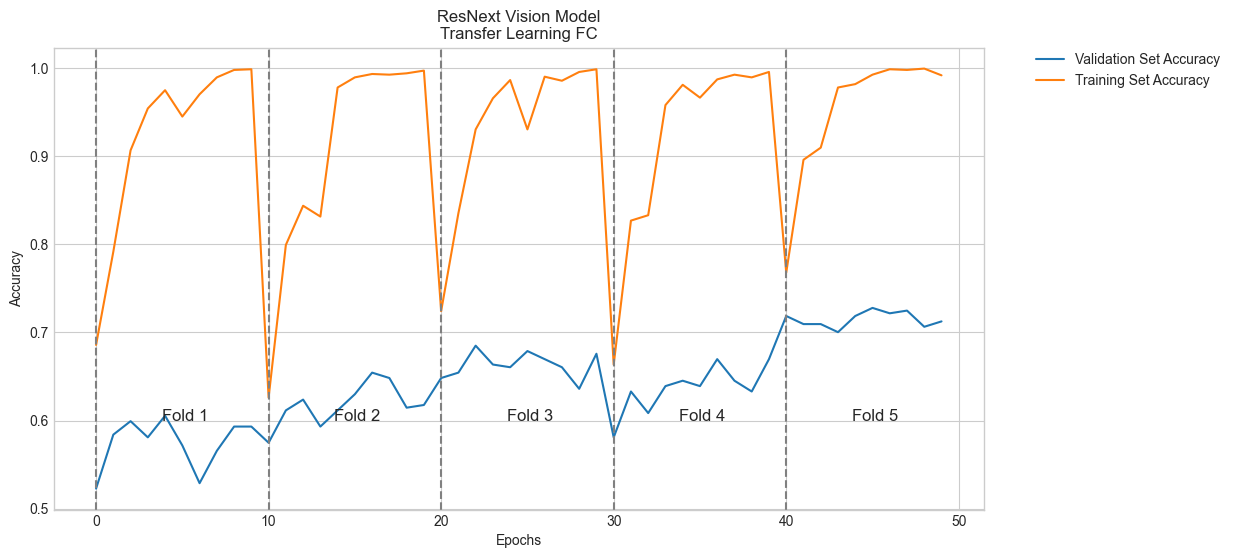

In [35]:
vgg16.requires_grad_(False)
torch.save(vgg16.state_dict(), "models/vgg16_24_5fold_10epoch.pt")

## Recostrucción del modelo

Reconstuimos el modelo original, sustituyendo las capas más específicas por las que hemos entrenado

In [40]:
model = nn.Sequential(
    models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1').features[:24],
    vgg16
)

In [41]:
classes = ['fake', 'real']

Comprobamos que el modelo compilado funciona correctamente con el dataset de imágenes

In [42]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.299, 0.224, 0.225]
    )
])

In [46]:
path = 'data/real_and_fake_face/training_fake/easy_110_0001.jpg'
img = Image.open(path)

img = transform(img)
img = img.unsqueeze(0)

out = model(img)
print("La clase predicha es:", classes[torch.argmax(out, dim=1)])

La clase predicha es: fake


In [47]:
dataset = torchvision.datasets.ImageFolder(
    root='data/real_and_fake_face',
    transform=transform
)

In [49]:
data_loader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)

In [50]:
acc = 0
for i, (image, label) in enumerate(data_loader, 1):
    image = image.to(device)
    label = label.to(device)

    output = model(image)
    acc += (torch.argmax(output, dim=1) == label).sum().item()

print("Se ha obtenido un accuracy del ", acc/len(dataset)*100, "% en el conjunto de test")

Se ha obtenido un accuracy del  76.04115629593336 % en el conjunto de test
